In [1]:
#%pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe matplotlib
#%pip install mediapipe

import cv2
from matplotlib import pyplot as plt
import mediapipe as mp
import numpy as np
import time

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands
mp_holistic = mp.solutions.holistic
mp_objectron = mp.solutions.objectron

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #BGR 2 RGB
    image.flags.writeable = False                  # Image not writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) 
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [5]:
def draw_styled_landmarks(image, results):
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(252, 169, 3), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(31, 0, 209), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(252, 169, 3), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(31, 0, 209), thickness=2, circle_radius=2)
                             )

In [47]:
def extract_keypoints(results):
    if results.left_hand_landmarks:
        leftHandKeypoints = np.array([[keypoint.x, keypoint.y, keypoint.z] for keypoint in results.left_hand_landmarks.landmark]).flatten()
    else:
        leftHandKeypoints = np.zeros(21*3)

    if results.right_hand_landmarks:
        rightHandKeypoints = np.array([[keypoint.x, keypoint.y, keypoint.z] for keypoint in results.right_hand_landmarks.landmark]).flatten()
    else:
        rightHandKeypoints = np.zeros(21*3)
    return np.concatenate([leftHandKeypoints, rightHandKeypoints])

In [48]:
# Path for exported data, numpy arrays
import os
DATA_PATH = os.path.join('FYPactions') 

# Actions that we try to detect
actions = np.array(['help', 'thief', 'pain'])
no_sequences = 30
sequence_length = 30

In [49]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [50]:
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
#     while cap.isOpened():
    for action in actions:
            # Loop through sequences aka videos
            for sequence in range(no_sequences):
                # Loop through video length aka sequence length
                for frame_num in range(sequence_length):
                    success, image = cap.read()
                    image.flags.writeable = False
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    results = holistic.process(image)

                    # Draw the hand annotations on the image.
                    image.flags.writeable = True
                    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                    if results.left_hand_landmarks:
                        mp_drawing.draw_landmarks(
                            image,
                            results.left_hand_landmarks,
                            mp_holistic.HAND_CONNECTIONS,
                            # mp_drawing_styles.get_default_hand_landmarks_style(),
                            # mp_drawing_styles.get_default_hand_connections_style()
                            mp_drawing.DrawingSpec(color=(252, 169, 3), thickness=2, circle_radius=2),
                            mp_drawing.DrawingSpec(color=(31, 0, 209), thickness=2, circle_radius=2))

                    if results.right_hand_landmarks:
                        mp_drawing.draw_landmarks(
                            image,
                            results.right_hand_landmarks,
                            mp_holistic.HAND_CONNECTIONS,
                            # mp_drawing_styles.get_default_hand_landmarks_style(),
                            # mp_drawing_styles.get_default_hand_connections_style()
                            mp_drawing.DrawingSpec(color=(252, 169, 3), thickness=2, circle_radius=2),
                            mp_drawing.DrawingSpec(color=(31, 0, 209), thickness=2, circle_radius=2))
                    # Flip the image horizontally for a selfie-view display.
                    if results.face_landmarks:
                        mp_drawing.draw_landmarks(
                            image,
                            results.face_landmarks,
                            mp_holistic.FACEMESH_CONTOURS,
                            # mp_drawing_styles.get_default_hand_landmarks_style(),
                            # mp_drawing_styles.get_default_hand_connections_style()
                            mp_drawing.DrawingSpec(color=(252, 169, 3), thickness=1, circle_radius=1),
                            mp_drawing.DrawingSpec(color=(227, 227, 227), thickness=1, circle_radius=1))
                    
                    if frame_num == 0: 
                        cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                        cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                        # Show to screen
                        cv2.imshow('OpenCV Feed', image)
                        cv2.waitKey(2000)
                    else: 
                        cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                        cv2.imshow('OpenCV Feed', image)
                        imgpath = 'C:\\Users\\roshan\\FYPAction Images'
                        #cv2.imwrite(os.path.join(imgpath,'FYPAction Images', '{}_{}'.format(action,sequence) ), cv2.flip(image, 1))
                    
                    keypoints = extract_keypoints(results)
                    npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                    np.save(npy_path, keypoints)
                    
                    if cv2.waitKey(10) & 0xFF == ord('q'):
                        break

cap.release()
cv2.destroyAllWindows()

**Testing the camera view

In [91]:
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        success, image = cap.read()
        image.flags.writeable = False
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = holistic.process(image)

        # Draw the hand annotations on the image.
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        if results.left_hand_landmarks:
            mp_drawing.draw_landmarks(
                image,
                results.left_hand_landmarks,
                mp_holistic.HAND_CONNECTIONS,
                # mp_drawing_styles.get_default_hand_landmarks_style(),
                # mp_drawing_styles.get_default_hand_connections_style()
                mp_drawing.DrawingSpec(color=(252, 169, 3), thickness=2, circle_radius=2),
                mp_drawing.DrawingSpec(color=(31, 0, 209), thickness=2, circle_radius=2))

        if results.right_hand_landmarks:
            mp_drawing.draw_landmarks(
                image,
                results.right_hand_landmarks,
                mp_holistic.HAND_CONNECTIONS,
                # mp_drawing_styles.get_default_hand_landmarks_style(),
                # mp_drawing_styles.get_default_hand_connections_style()
                mp_drawing.DrawingSpec(color=(252, 169, 3), thickness=2, circle_radius=2),
                mp_drawing.DrawingSpec(color=(31, 0, 209), thickness=2, circle_radius=2))
        # Flip the image horizontally for a selfie-view display.
        if results.face_landmarks:
            mp_drawing.draw_landmarks(
                image,
                results.face_landmarks,
                mp_holistic.FACEMESH_CONTOURS,
                # mp_drawing_styles.get_default_hand_landmarks_style(),
                # mp_drawing_styles.get_default_hand_connections_style()
                mp_drawing.DrawingSpec(color=(252, 169, 3), thickness=1, circle_radius=1),
                mp_drawing.DrawingSpec(color=(227, 227, 227), thickness=1, circle_radius=1))

        cv2.imshow('Hands Keypoints', cv2.flip(image, 1))
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

In [90]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [52]:
plt.savefig('Testing the Keypoints in real time')

In [53]:
#results.left_hand_landmarks.landmark

<IPython.core.display.Javascript object>


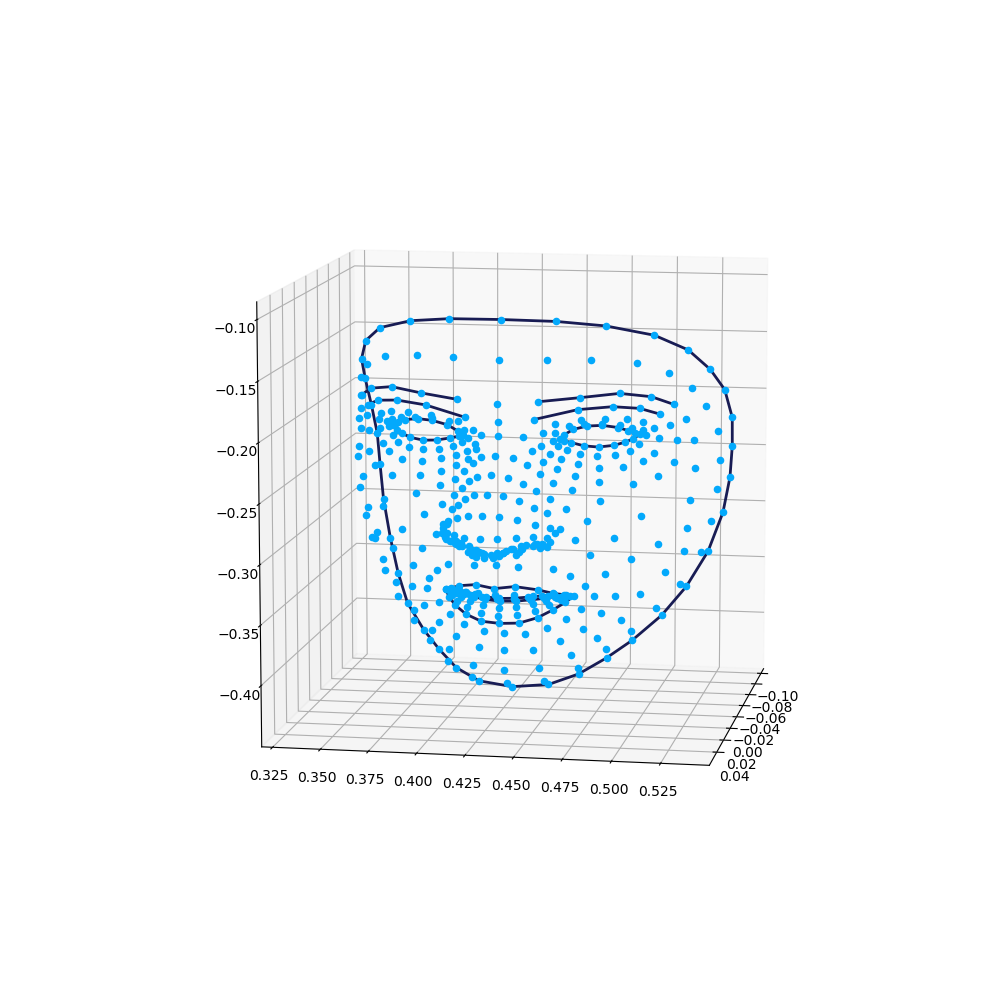

In [54]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D 
imag1 = mp_drawing.plot_landmarks(
    results.face_landmarks,
    mp_holistic.FACEMESH_CONTOURS,
    # mp_drawing_styles.get_default_hand_landmarks_style(),
    # mp_drawing_styles.get_default_hand_connections_style()
    mp_drawing.DrawingSpec(color=(252, 169, 3), thickness=1, circle_radius=1),
    mp_drawing.DrawingSpec(color=(84, 28, 24), thickness=2, circle_radius=2)
)

imag = mp_drawing.plot_landmarks(
    results.left_hand_landmarks,
    mp_holistic.HAND_CONNECTIONS,
    # mp_drawing_styles.get_default_hand_landmarks_style(),
    # mp_drawing_styles.get_default_hand_connections_style()
    mp_drawing.DrawingSpec(color=(0, 50, 3), thickness=1, circle_radius=1),
    mp_drawing.DrawingSpec(color=(0, 140, 245), thickness=2, circle_radius=2)
)


In [37]:
plt.savefig('keypoints_face')

<b>Extracting the Keypoints</b>
>Keypoints of left and right hand are stored inside their respective
 one dimenional arrays

In [55]:
resulttest = extract_keypoints(results)

In [56]:
np.save('0', resulttest)

In [57]:
np.load('0.npy')

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.18692426,  0.63785547,
        0.        ,  0.23164466,  0.60217512, -0.02415338,  0.27

In [41]:
# with mp_objectron.Objectron() as objectron:
#     result2 = objectron.process(image)

# print(result2.detected_objects)

In [16]:
for action in actions: 
    dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
    for sequence in range(1,no_sequences+1):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(dirmax+sequence)))
        except:
            pass

In [58]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [59]:
label_map = {label:num for num, label in enumerate(actions)}

In [60]:
label_map

{'help': 0, 'thief': 1, 'pain': 2}

In [61]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [62]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)


In [63]:
#%pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [64]:
X.shape

(90, 30, 126)

In [65]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [66]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,126)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [67]:
res = [.7, 0.2, 0.1]

In [68]:
actions[np.argmax(res)]

'help'

In [92]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])


In [93]:
model.fit(X_train, y_train, epochs=800, callbacks=[tb_callback])


Epoch 1/800
3/3 [==============================] - 8s 697ms/step - loss: 1.4025e-09 - categorical_accuracy: 1.0000
Epoch 2/800
3/3 [==============================] - 0s 56ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 3/800
3/3 [==============================] - 0s 52ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 4/800
3/3 [==============================] - 0s 72ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 5/800
3/3 [==============================] - 0s 52ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 6/800
3/3 [==============================] - 0s 61ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 7/800
3/3 [==============================] - 0s 61ms/step - loss: 1.4025e-09 - categorical_accuracy: 1.0000
Epoch 8/800
3/3 [==============================] - 0s 61ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 9/800
3/3 [==============================] - 0s 69ms/step - loss: 0.0000e+00 - ca

3/3 [==============================] - 0s 54ms/step - loss: 3.7925e-04 - categorical_accuracy: 1.0000
Epoch 74/800
3/3 [==============================] - 0s 67ms/step - loss: 3.4954e-04 - categorical_accuracy: 1.0000
Epoch 75/800
3/3 [==============================] - 0s 52ms/step - loss: 3.2312e-04 - categorical_accuracy: 1.0000
Epoch 76/800
3/3 [==============================] - 0s 61ms/step - loss: 2.9505e-04 - categorical_accuracy: 1.0000
Epoch 77/800
3/3 [==============================] - 0s 55ms/step - loss: 2.7699e-04 - categorical_accuracy: 1.0000
Epoch 78/800
3/3 [==============================] - 0s 67ms/step - loss: 2.5617e-04 - categorical_accuracy: 1.0000
Epoch 79/800
3/3 [==============================] - 0s 45ms/step - loss: 2.4139e-04 - categorical_accuracy: 1.0000
Epoch 80/800
3/3 [==============================] - 0s 52ms/step - loss: 2.2554e-04 - categorical_accuracy: 1.0000
Epoch 81/800
3/3 [==============================] - 0s 63ms/step - loss: 2.0814e-04 - categor

3/3 [==============================] - 0s 78ms/step - loss: 2.0198e-05 - categorical_accuracy: 1.0000
Epoch 144/800
3/3 [==============================] - 0s 66ms/step - loss: 1.9728e-05 - categorical_accuracy: 1.0000
Epoch 145/800
3/3 [==============================] - 0s 62ms/step - loss: 1.9278e-05 - categorical_accuracy: 1.0000
Epoch 146/800
3/3 [==============================] - 0s 69ms/step - loss: 1.8825e-05 - categorical_accuracy: 1.0000
Epoch 147/800
3/3 [==============================] - 0s 60ms/step - loss: 1.8519e-05 - categorical_accuracy: 1.0000
Epoch 148/800
3/3 [==============================] - 0s 71ms/step - loss: 1.8186e-05 - categorical_accuracy: 1.0000
Epoch 149/800
3/3 [==============================] - 0s 67ms/step - loss: 1.7680e-05 - categorical_accuracy: 1.0000
Epoch 150/800
3/3 [==============================] - 0s 64ms/step - loss: 1.7437e-05 - categorical_accuracy: 1.0000
Epoch 151/800
3/3 [==============================] - 0s 67ms/step - loss: 1.6981e-05 -

3/3 [==============================] - 0s 93ms/step - loss: 6.1872e-06 - categorical_accuracy: 1.0000
Epoch 213/800
3/3 [==============================] - 0s 89ms/step - loss: 6.0919e-06 - categorical_accuracy: 1.0000
Epoch 214/800
3/3 [==============================] - 0s 55ms/step - loss: 6.0105e-06 - categorical_accuracy: 1.0000
Epoch 215/800
3/3 [==============================] - 0s 64ms/step - loss: 5.9306e-06 - categorical_accuracy: 1.0000
Epoch 216/800
3/3 [==============================] - 0s 63ms/step - loss: 5.8787e-06 - categorical_accuracy: 1.0000
Epoch 217/800
3/3 [==============================] - 0s 60ms/step - loss: 5.8128e-06 - categorical_accuracy: 1.0000
Epoch 218/800
3/3 [==============================] - 0s 76ms/step - loss: 5.7273e-06 - categorical_accuracy: 1.0000
Epoch 219/800
3/3 [==============================] - 0s 65ms/step - loss: 5.6487e-06 - categorical_accuracy: 1.0000
Epoch 220/800
3/3 [==============================] - 0s 63ms/step - loss: 5.5898e-06 -

3/3 [==============================] - 0s 49ms/step - loss: 2.9072e-06 - categorical_accuracy: 1.0000
Epoch 283/800
3/3 [==============================] - 0s 49ms/step - loss: 2.8749e-06 - categorical_accuracy: 1.0000
Epoch 284/800
3/3 [==============================] - 0s 51ms/step - loss: 2.8371e-06 - categorical_accuracy: 1.0000
Epoch 285/800
3/3 [==============================] - 0s 53ms/step - loss: 2.8259e-06 - categorical_accuracy: 1.0000
Epoch 286/800
3/3 [==============================] - 0s 53ms/step - loss: 2.7978e-06 - categorical_accuracy: 1.0000
Epoch 287/800
3/3 [==============================] - 0s 57ms/step - loss: 2.7627e-06 - categorical_accuracy: 1.0000
Epoch 288/800
3/3 [==============================] - 0s 69ms/step - loss: 2.7417e-06 - categorical_accuracy: 1.0000
Epoch 289/800
3/3 [==============================] - 0s 69ms/step - loss: 2.7193e-06 - categorical_accuracy: 1.0000
Epoch 290/800
3/3 [==============================] - 0s 60ms/step - loss: 2.6884e-06 -

3/3 [==============================] - 0s 56ms/step - loss: 1.6072e-06 - categorical_accuracy: 1.0000
Epoch 353/800
3/3 [==============================] - 0s 49ms/step - loss: 1.5946e-06 - categorical_accuracy: 1.0000
Epoch 354/800
3/3 [==============================] - 0s 56ms/step - loss: 1.5833e-06 - categorical_accuracy: 1.0000
Epoch 355/800
3/3 [==============================] - 0s 52ms/step - loss: 1.5763e-06 - categorical_accuracy: 1.0000
Epoch 356/800
3/3 [==============================] - 0s 49ms/step - loss: 1.5665e-06 - categorical_accuracy: 1.0000
Epoch 357/800
3/3 [==============================] - 0s 49ms/step - loss: 1.5525e-06 - categorical_accuracy: 1.0000
Epoch 358/800
3/3 [==============================] - 0s 49ms/step - loss: 1.5399e-06 - categorical_accuracy: 1.0000
Epoch 359/800
3/3 [==============================] - 0s 46ms/step - loss: 1.5399e-06 - categorical_accuracy: 1.0000
Epoch 360/800
3/3 [==============================] - 0s 54ms/step - loss: 1.5272e-06 -

3/3 [==============================] - 0s 55ms/step - loss: 1.0098e-06 - categorical_accuracy: 1.0000
Epoch 423/800
3/3 [==============================] - 0s 44ms/step - loss: 1.0013e-06 - categorical_accuracy: 1.0000
Epoch 424/800
3/3 [==============================] - 0s 44ms/step - loss: 9.9433e-07 - categorical_accuracy: 1.0000
Epoch 425/800
3/3 [==============================] - 0s 40ms/step - loss: 9.9012e-07 - categorical_accuracy: 1.0000
Epoch 426/800
3/3 [==============================] - 0s 43ms/step - loss: 9.8732e-07 - categorical_accuracy: 1.0000
Epoch 427/800
3/3 [==============================] - 0s 69ms/step - loss: 9.8031e-07 - categorical_accuracy: 1.0000
Epoch 428/800
3/3 [==============================] - 0s 59ms/step - loss: 9.7189e-07 - categorical_accuracy: 1.0000
Epoch 429/800
3/3 [==============================] - 0s 67ms/step - loss: 9.6628e-07 - categorical_accuracy: 1.0000
Epoch 430/800
3/3 [==============================] - 0s 61ms/step - loss: 9.6067e-07 -

3/3 [==============================] - 0s 49ms/step - loss: 6.6756e-07 - categorical_accuracy: 1.0000
Epoch 493/800
3/3 [==============================] - 0s 59ms/step - loss: 6.6195e-07 - categorical_accuracy: 1.0000 0s - loss: 6.6195e-07 - categorical_accuracy: 1.00
Epoch 494/800
3/3 [==============================] - 0s 54ms/step - loss: 6.5915e-07 - categorical_accuracy: 1.0000
Epoch 495/800
3/3 [==============================] - 0s 47ms/step - loss: 6.5915e-07 - categorical_accuracy: 1.0000
Epoch 496/800
3/3 [==============================] - 0s 49ms/step - loss: 6.5354e-07 - categorical_accuracy: 1.0000
Epoch 497/800
3/3 [==============================] - 0s 49ms/step - loss: 6.5074e-07 - categorical_accuracy: 1.0000
Epoch 498/800
3/3 [==============================] - 0s 45ms/step - loss: 6.4793e-07 - categorical_accuracy: 1.0000
Epoch 499/800
3/3 [==============================] - 0s 48ms/step - loss: 6.4372e-07 - categorical_accuracy: 1.0000
Epoch 500/800
3/3 [================

3/3 [==============================] - 0s 50ms/step - loss: 4.7403e-07 - categorical_accuracy: 1.0000
Epoch 563/800
3/3 [==============================] - 0s 46ms/step - loss: 4.7263e-07 - categorical_accuracy: 1.0000
Epoch 564/800
3/3 [==============================] - 0s 42ms/step - loss: 4.6702e-07 - categorical_accuracy: 1.0000
Epoch 565/800
3/3 [==============================] - 0s 52ms/step - loss: 4.6702e-07 - categorical_accuracy: 1.0000
Epoch 566/800
3/3 [==============================] - 0s 57ms/step - loss: 4.6561e-07 - categorical_accuracy: 1.0000
Epoch 567/800
3/3 [==============================] - 0s 57ms/step - loss: 4.6281e-07 - categorical_accuracy: 1.0000
Epoch 568/800
3/3 [==============================] - 0s 60ms/step - loss: 4.6141e-07 - categorical_accuracy: 1.0000
Epoch 569/800
3/3 [==============================] - 0s 61ms/step - loss: 4.6000e-07 - categorical_accuracy: 1.0000
Epoch 570/800
3/3 [==============================] - 0s 54ms/step - loss: 4.5860e-07 -

3/3 [==============================] - 0s 48ms/step - loss: 3.4781e-07 - categorical_accuracy: 1.0000
Epoch 633/800
3/3 [==============================] - 0s 43ms/step - loss: 3.4641e-07 - categorical_accuracy: 1.0000
Epoch 634/800
3/3 [==============================] - 0s 43ms/step - loss: 3.4500e-07 - categorical_accuracy: 1.0000
Epoch 635/800
3/3 [==============================] - 0s 49ms/step - loss: 3.4360e-07 - categorical_accuracy: 1.0000
Epoch 636/800
3/3 [==============================] - 0s 61ms/step - loss: 3.4220e-07 - categorical_accuracy: 1.0000
Epoch 637/800
3/3 [==============================] - 0s 45ms/step - loss: 3.4220e-07 - categorical_accuracy: 1.0000
Epoch 638/800
3/3 [==============================] - 0s 42ms/step - loss: 3.4080e-07 - categorical_accuracy: 1.0000
Epoch 639/800
3/3 [==============================] - 0s 46ms/step - loss: 3.3799e-07 - categorical_accuracy: 1.0000
Epoch 640/800
3/3 [==============================] - 0s 45ms/step - loss: 3.3799e-07 -

3/3 [==============================] - 0s 60ms/step - loss: 2.6506e-07 - categorical_accuracy: 1.0000
Epoch 703/800
3/3 [==============================] - 0s 48ms/step - loss: 2.6366e-07 - categorical_accuracy: 1.0000
Epoch 704/800
3/3 [==============================] - 0s 48ms/step - loss: 2.6366e-07 - categorical_accuracy: 1.0000
Epoch 705/800
3/3 [==============================] - 0s 47ms/step - loss: 2.5945e-07 - categorical_accuracy: 1.0000
Epoch 706/800
3/3 [==============================] - ETA: 0s - loss: 2.9988e-07 - categorical_accuracy: 1.00 - 0s 52ms/step - loss: 2.5805e-07 - categorical_accuracy: 1.0000
Epoch 707/800
3/3 [==============================] - 0s 51ms/step - loss: 2.5665e-07 - categorical_accuracy: 1.0000
Epoch 708/800
3/3 [==============================] - 0s 49ms/step - loss: 2.5525e-07 - categorical_accuracy: 1.0000
Epoch 709/800
3/3 [==============================] - 0s 51ms/step - loss: 2.5525e-07 - categorical_accuracy: 1.0000
Epoch 710/800
3/3 [=========

3/3 [==============================] - 0s 47ms/step - loss: 2.0336e-07 - categorical_accuracy: 1.0000
Epoch 772/800
3/3 [==============================] - 0s 47ms/step - loss: 2.0195e-07 - categorical_accuracy: 1.0000
Epoch 773/800
3/3 [==============================] - 0s 51ms/step - loss: 2.0195e-07 - categorical_accuracy: 1.0000
Epoch 774/800
3/3 [==============================] - 0s 49ms/step - loss: 2.0055e-07 - categorical_accuracy: 1.0000
Epoch 775/800
3/3 [==============================] - 0s 50ms/step - loss: 2.0055e-07 - categorical_accuracy: 1.0000
Epoch 776/800
3/3 [==============================] - 0s 50ms/step - loss: 2.0055e-07 - categorical_accuracy: 1.0000
Epoch 777/800
3/3 [==============================] - 0s 47ms/step - loss: 2.0055e-07 - categorical_accuracy: 1.0000
Epoch 778/800
3/3 [==============================] - 0s 46ms/step - loss: 1.9775e-07 - categorical_accuracy: 1.0000
Epoch 779/800
3/3 [==============================] - 0s 47ms/step - loss: 1.9634e-07 -

In [73]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30, 64)            48896     
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 203,459
Trainable params: 203,459
Non-trainable params: 0
________________________________________________

In [74]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [75]:
res = model.predict(X_test)

In [78]:
actions[np.argmax(res[2])]

'thief'

In [80]:
actions[np.argmax(y_test[2])]

'thief'

In [82]:
model.save('final_accuracy.h5')

In [83]:
#%pip install sklearn


In [85]:
model.load_weights('final_accuracy.h5')

In [86]:
colors = [(15,117,116), (177,25,16), (126,117,205)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

<IPython.core.display.Javascript object>


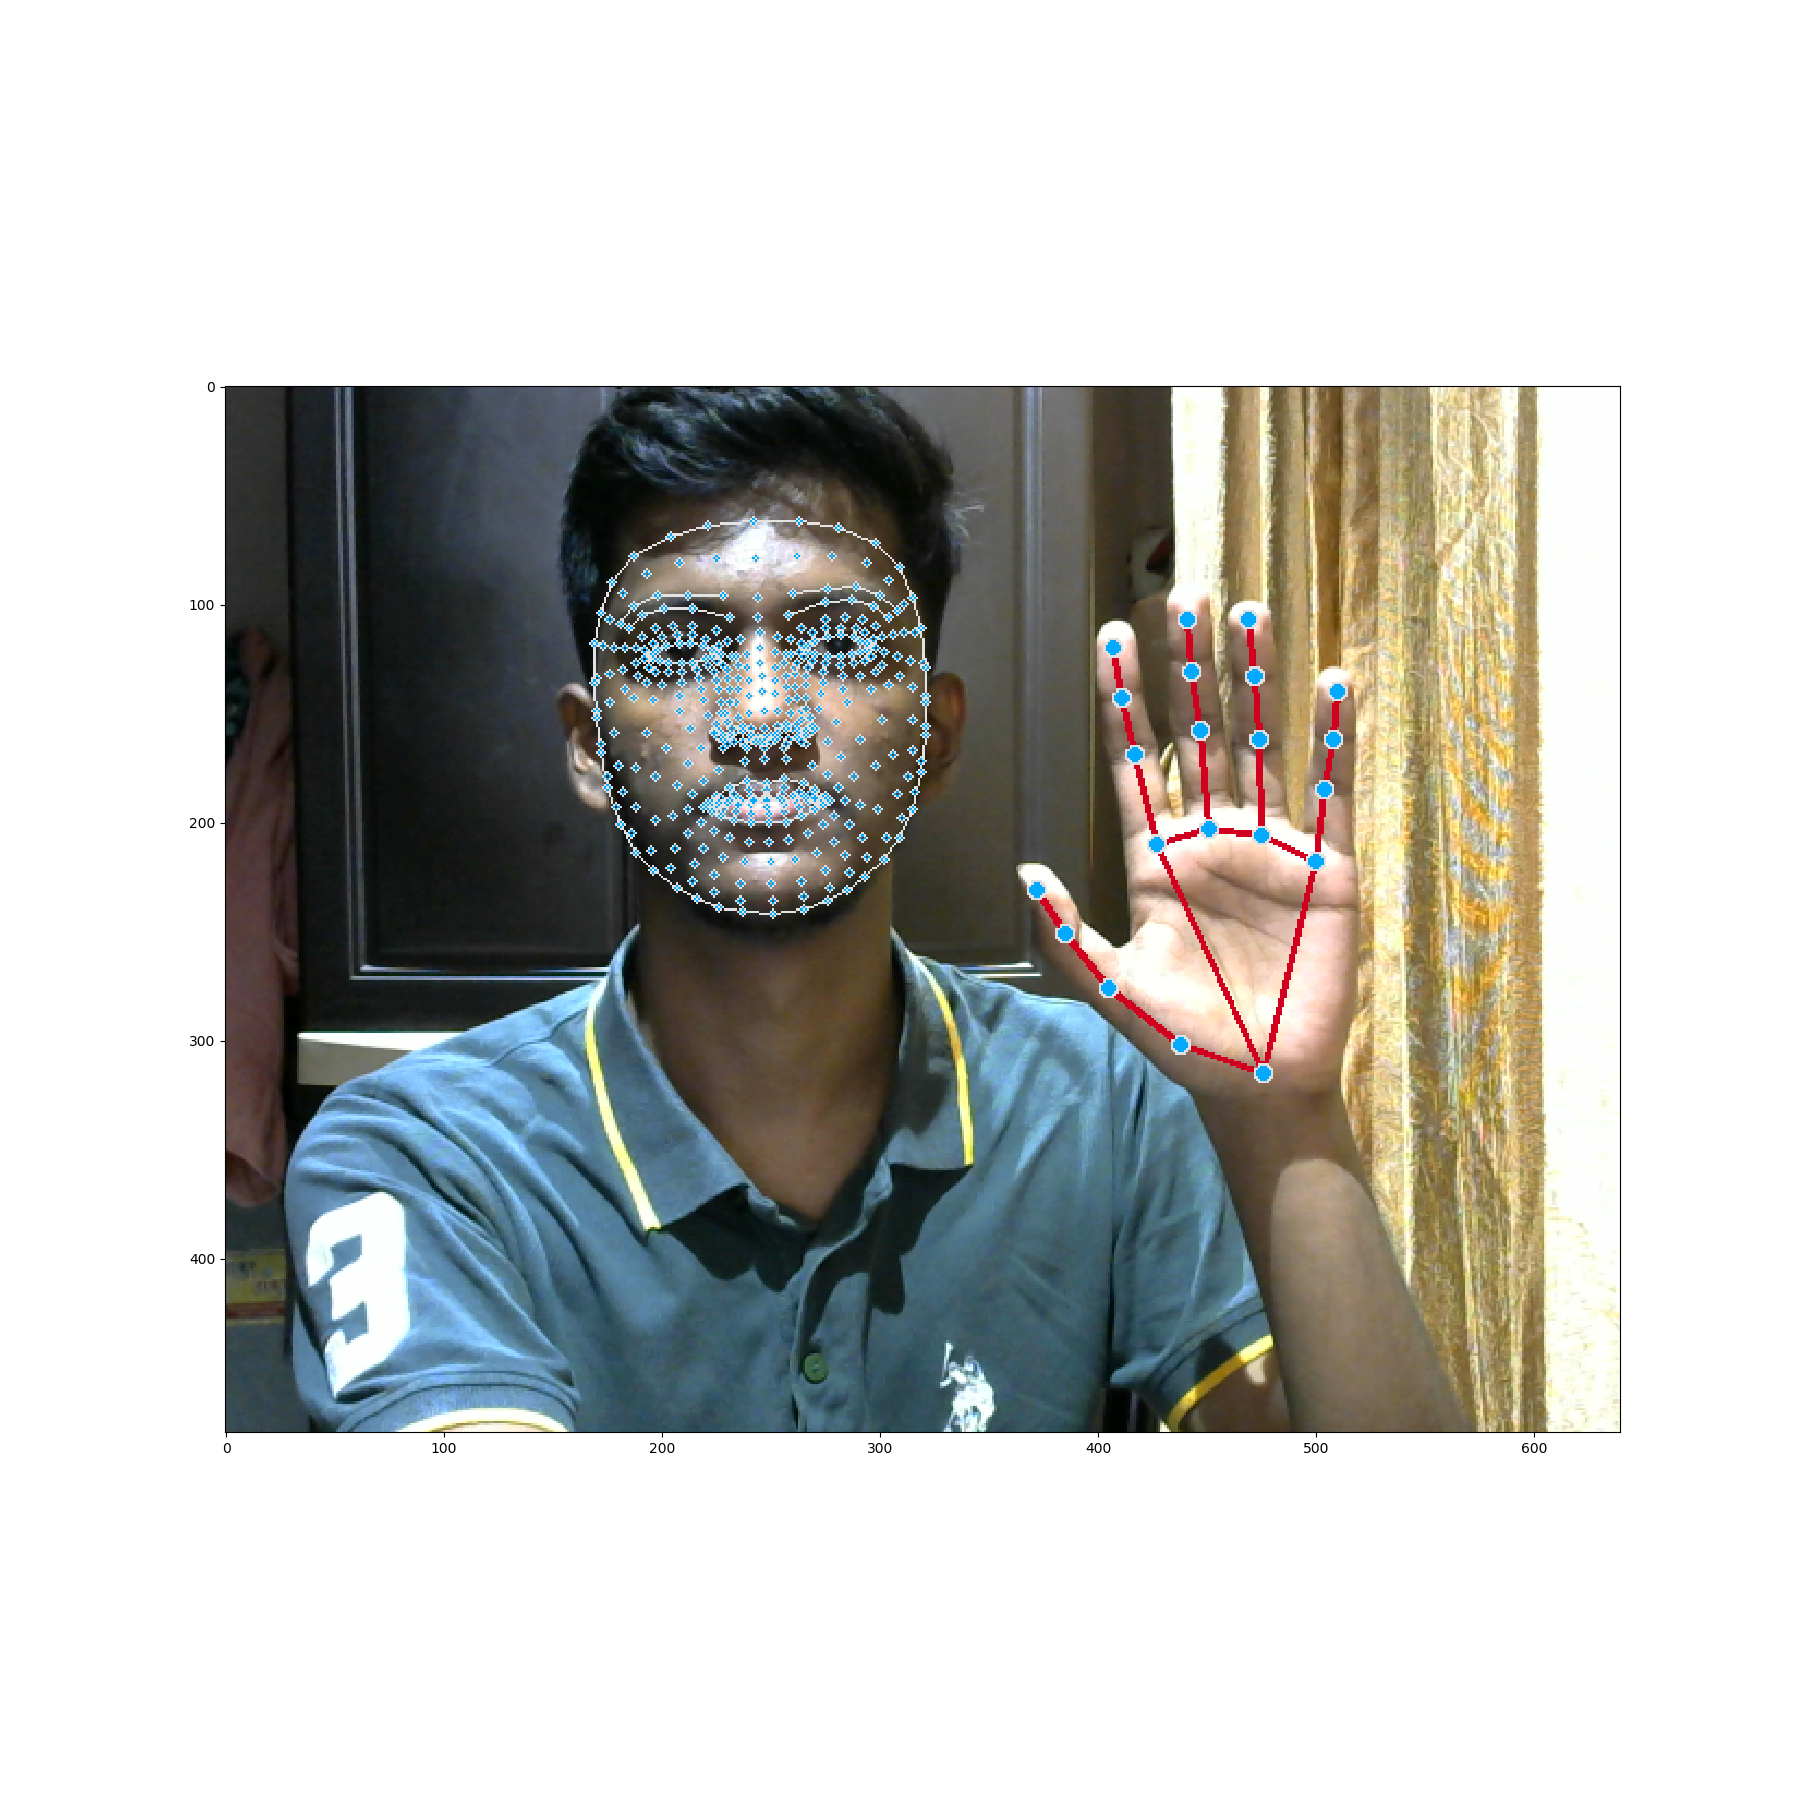

TypeError: only size-1 arrays can be converted to Python scalars

In [87]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [94]:
sequence = []
sentence = []
threshold = 0.7

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

#             if len(sentence) > 5: 
#                 sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
#         cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
#         cv2.putText(image, ' '.join(sentence), (3,30), 
#                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class '

pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<cl

<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class '

thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOu

help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<cl

<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'

thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutp

<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief


thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOut

<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>


thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOu

<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class

<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class '

pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<cl

pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<cl

pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<cl

<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class '

<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class '

pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<cl

thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain


pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<cl

pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief

<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class '

<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class '

<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class '

<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'

help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<class 'mediapipe.python.solution_base.SolutionOutputs'>
help
<cl

<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pain
<class

thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thief
<class 'mediapipe.python.solution_base.SolutionOu